In [21]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [22]:
df = pd.read_csv('testset.csv')
df.head()

,datetime_utc,_conds,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wdire,_wgustm,_windchillm,_wspdm
0,19961101-11:00,Smoke,9.0,0,0,NaN,27.0,NaN,1010.0,0,0,30.0,0,0,5.0,280.0,West,NaN,NaN,7.4
1,19961101-12:00,Smoke,10.0,0,0,NaN,32.0,NaN,-9999.0,0,0,28.0,0,0,NaN,0.0,North,NaN,NaN,NaN
2,19961101-13:00,Smoke,11.0,0,0,NaN,44.0,NaN,-9999.0,0,0,24.0,0,0,NaN,0.0,North,NaN,NaN,NaN
3,19961101-14:00,Smoke,10.0,0,0,NaN,41.0,NaN,1010.0,0,0,24.0,0,0,2.0,0.0,North,NaN,NaN,NaN
4,19961101-16:00,Smoke,11.0,0,0,NaN,47.0,NaN,1011.0,0,0,23.0,0,0,1.2,0.0,North,NaN,NaN,0.0


In [23]:
df.tail()

,datetime_utc,_conds,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wdire,_wgustm,_windchillm,_wspdm
100985,20170424-06:00,Haze,17.0,0,0,NaN,25.0,NaN,1005.0,0,0,34.0,0,0,4.0,320.0,NW,NaN,NaN,11.1
100986,20170424-09:00,Haze,14.0,0,0,NaN,16.0,NaN,1003.0,0,0,38.0,0,0,4.0,320.0,NW,NaN,NaN,22.2
100987,20170424-12:00,Haze,12.0,0,0,NaN,14.0,NaN,1002.0,0,0,36.0,0,0,4.0,270.0,West,NaN,NaN,18.5
100988,20170424-15:00,Haze,15.0,0,0,NaN,27.0,NaN,1004.0,0,0,32.0,0,0,2.0,320.0,NW,NaN,NaN,3.7
100989,20170424-18:00,Haze,15.0,0,0,NaN,30.0,NaN,1005.0,0,0,30.0,0,0,2.0,320.0,NW,NaN,NaN,3.7


In [24]:
df.shape

(100990, 20)

In [25]:
df.isnull().sum()

datetime_utc         0
 _conds             72
 _dewptm           621
 _fog                0
 _hail               0
 _heatindexm     71835
 _hum              757
 _precipm       100990
 _pressurem        232
 _rain               0
 _snow               0
 _tempm            673
 _thunder            0
 _tornado            0
 _vism            4428
 _wdird          14755
 _wdire          14755
 _wgustm         99918
 _windchillm    100411
 _wspdm           2358
dtype: int64

In [28]:
df['datetime_utc']=pd.to_datetime(df['datetime_utc'])
df[' _tempm'].fillna(df[' _tempm'].mean(), inplace=True)
df = df[['datetime_utc',' _tempm' ]]
df.head()

,datetime_utc,_tempm
0,1996-11-01 11:00:00,30.0
1,1996-11-01 12:00:00,28.0
2,1996-11-01 13:00:00,24.0
3,1996-11-01 14:00:00,24.0
4,1996-11-01 16:00:00,23.0


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100990 entries, 0 to 100989
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   datetime_utc  100990 non-null  datetime64[ns]
 1    _tempm       100990 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.5 MB


In [34]:
delhi=df[['datetime_utc',' _tempm']].copy()
delhi['just_date'] = delhi['datetime_utc'].dt.date

delhinew=delhi.drop('datetime_utc',axis=1)
delhinew.set_index('just_date', inplace= True)
delhinew.head()

,_tempm
just_date,
1996-11-01,30.0
1996-11-01,28.0
1996-11-01,24.0
1996-11-01,24.0
1996-11-01,23.0


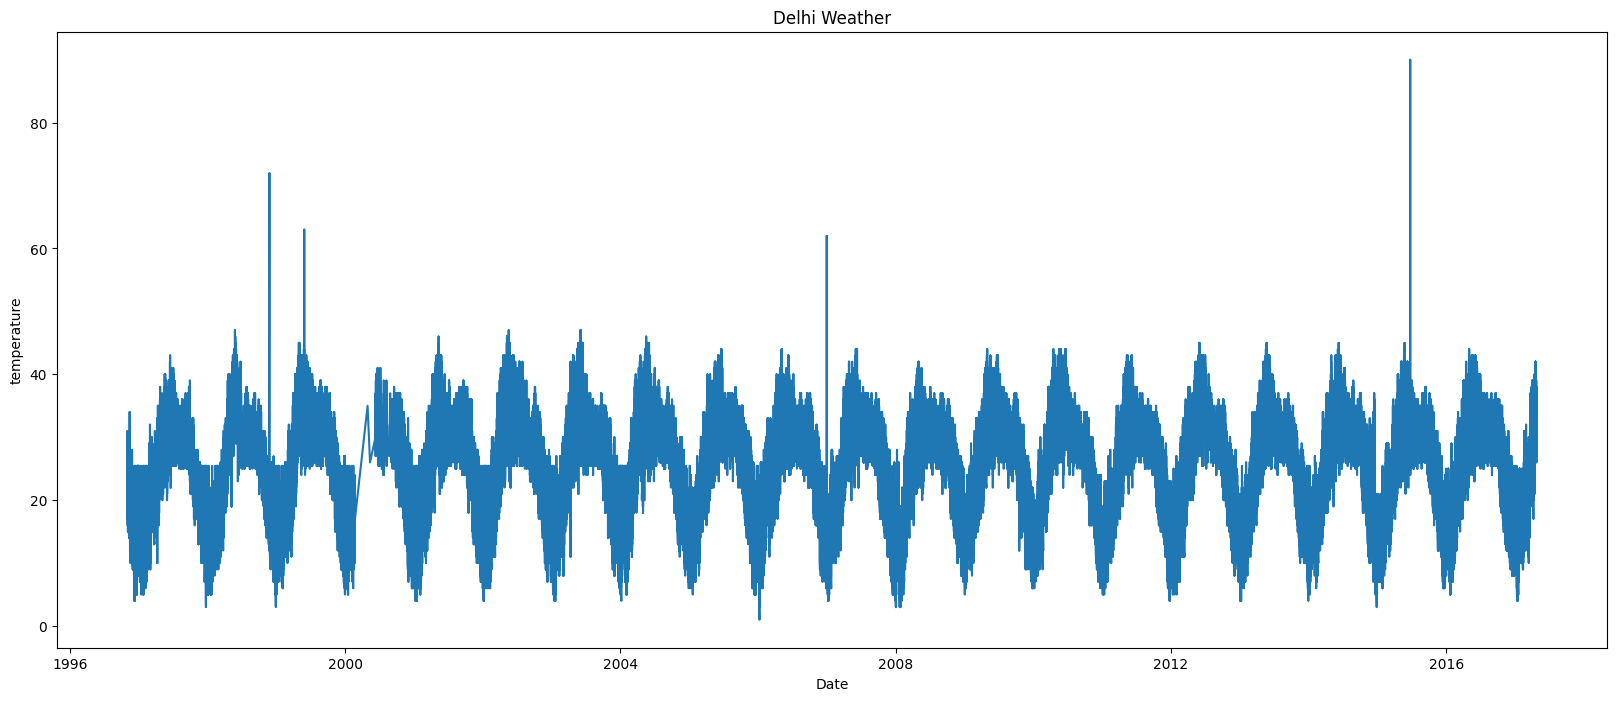

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,8))
plt.plot(delhinew)
plt.title('Delhi Weather')
plt.xlabel('Date')
plt.ylabel('temperature')
plt.show()

In [37]:
dates = df['datetime_utc'].values
temp = df[' _tempm'].values

In [38]:
x_train, x_test, y_train, y_test = train_test_split(temp, dates, test_size = 0.2,
                                                    random_state = 0 , shuffle=False)

In [39]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [40]:
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=5000)
val_set = windowed_dataset(x_test, window_size=60, batch_size=100, shuffle_buffer=5000)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[64, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

In [43]:
max = df[' _tempm'].max()
min = df[' _tempm'].min()
x = (max - min) * (10 / 100)
print(x)

8.9


In [45]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('mae') < x and logs.get('val_mae') < x:
      print("\nmae telah mencapai <10%!")
      self.model.stop_training = True
callbacks = myCallback()

In [46]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [47]:
tf.keras.backend.set_floatx('float64')
history = model.fit(train_set ,epochs=100, validation_data=val_set, callbacks=[callbacks])

Epoch 1/100
808/808 [==============================] - 178s 215ms/step - loss: 99.2553 - mae: 99.7540 - val_loss: 5.3683 - val_mae: 5.8558
Epoch 2/100
808/808 [==============================] - 172s 211ms/step - loss: 28.2454 - mae: 28.7418 - val_loss: 6.8475 - val_mae: 7.3340
Epoch 3/100
808/808 [==============================] - 164s 202ms/step - loss: 22.2386 - mae: 22.7341 - val_loss: 6.7655 - val_mae: 7.2512
Epoch 4/100
808/808 [==============================] - 163s 200ms/step - loss: 18.5791 - mae: 19.0735 - val_loss: 6.4552 - val_mae: 6.9422
Epoch 5/100
808/808 [==============================] - 163s 201ms/step - loss: 15.4801 - mae: 15.9731 - val_loss: 5.2202 - val_mae: 5.7025
Epoch 6/100
808/808 [==============================] - 162s 200ms/step - loss: 12.9372 - mae: 13.4293 - val_loss: 4.8057 - val_mae: 5.2862
Epoch 7/100
808/808 [==============================] - 157s 193ms/step - loss: 11.1607 - mae: 11.6517 - val_loss: 4.8987 - val_mae: 5.3803
Epoch 8/100
808/808 [======

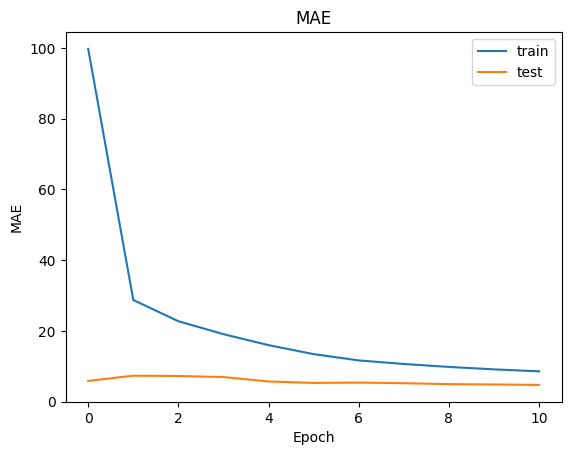

In [48]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

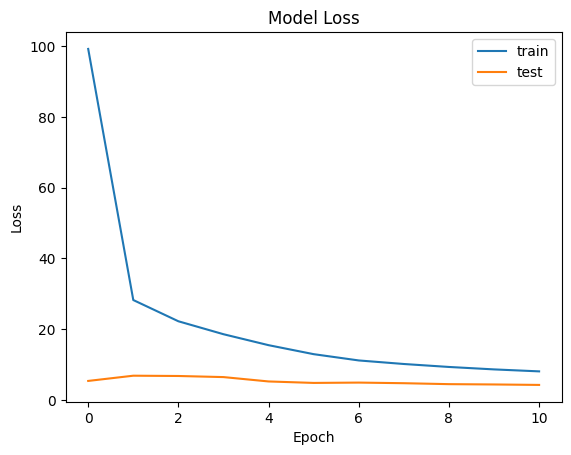

In [49]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()